# Project 3 - Behavioral Cloning

Import all modules.

In [2]:
import keras
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import csv
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D
import json

print('Modules loaded successfully.')

Modules loaded successfully.


## Load all data (images + steering angle).

In [2]:
loadAllImages = 1

if loadAllImages == 1:
    
    # Training Data.
    imgfilenames = sorted(os.listdir('data/controller/training/IMG'))
    
    imgfilenamescenter = imgfilenames[0:11224] # Only images from the center camera are used.
    
    print(len(imgfilenamescenter)) 
    print('First image: ' + imgfilenamescenter[0] + '\nLast image: ' + imgfilenamescenter[-1])
    
    allimages = np.zeros([11224,160,320,3], dtype='uint8')
    
    i = -1
    for imgname in imgfilenamescenter:
        i += 1
        # Read in the image.
        
        imgfullname = 'data/controller/training/IMG/' + imgname
        allimages[i] = mpimg.imread(imgfullname)
        
    # Test Data.
    imgfilenames = sorted(os.listdir('data/controller/test/IMG'))
    
    imgfilenamescenter = imgfilenames[0:821] # Only images from the center camera are used.
    
    print(len(imgfilenamescenter)) 
    print('First image: ' + imgfilenamescenter[0] + '\nLast image: ' + imgfilenamescenter[-1])
    
    allimages_test = np.zeros([821,160,320,3], dtype='uint8')
    
    i = -1
    for imgname in imgfilenamescenter:
        i += 1
        # Read in the image.
        
        imgfullname = 'data/controller/test/IMG/' + imgname
        allimages_test[i] = mpimg.imread(imgfullname)
        
    print("All Images Loaded.")    

11224
First image: center_2016_12_04_11_39_34_535.jpg
Last image: center_2016_12_09_15_06_54_639.jpg
821
First image: center_2016_12_04_11_54_37_548.jpg
Last image: center_2016_12_04_11_56_02_501.jpg
All Images Loaded.


In [3]:
loadAllSteering = 1

if loadAllSteering == 1:
    
    # Training Data.
    steeringdatafile = pd.read_csv('data/controller/training/driving_log.csv')
    allsteer = steeringdatafile['Steering'] #you can also use df['column_name']
    
    steername = steeringdatafile['Center']
    
    print(len(steername))
    print('First image: ' + steername[0] + '\nLast image: ' + steername[11223])
    
    steeringdatafile = None
    # Test Data.
    steeringdatafile = pd.read_csv('data/controller/test/driving_log.csv')
    allsteer_test = steeringdatafile['Steering'] #you can also use df['column_name']
    
    steername_test = steeringdatafile['Center']
    
    print(len(steername_test))
    print('First image: ' + steername_test[0] + '\nLast image: ' + steername_test[820])
    
    print('Steering Angle Loaded.')

11224
First image: C:\Users\Daniel\Downloads\simulator-windows-64\data\training\IMG\center_2016_12_04_11_39_34_535.jpg
Last image: C:\Users\Daniel\Downloads\simulator-windows-64\training-linux\training\IMG\center_2016_12_09_15_06_54_639.jpg
821
First image: C:\Users\Daniel\Downloads\simulator-windows-64\data\test\IMG\center_2016_12_04_11_54_37_548.jpg
Last image: C:\Users\Daniel\Downloads\simulator-windows-64\data\test\IMG\center_2016_12_04_11_56_02_501.jpg
Steering Angle Loaded.


## Verify collected data.

Images: 11224
Height: 160
Width: 320
Colors: 3


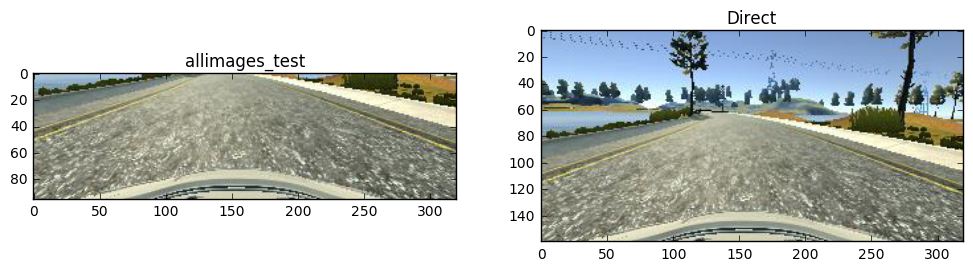

-0.03773971


In [4]:
verify = 1

if verify == 1:

    testimage = 300

    print('Images: ' +str(len(allimages)) )
    print('Height: ' +str(len(allimages[0])) )
    print('Width: ' +str(len(allimages[0,0])) )
    print('Colors: ' +str(len(allimages[0,0,0])) )


    tempimg = mpimg.imread('data/controller/test/IMG/' + imgfilenamescenter[testimage])



    fig = plt.figure(figsize=(12, 4))
    figinfo = fig.add_subplot(1,2,1)
    plt.imshow(allimages_test[testimage,65:160])
    figinfo.set_title('allimages_test')

    figinfo=fig.add_subplot(1,2,2)
    plt.imshow(tempimg)
    figinfo.set_title('Direct')

    plt.show()

    print(allsteer[3])

## Prepare Data for Keras.

In [5]:
print('Data count of 32x32 color image: ' + str(32 * 32 *3) )
print('Data count of 160x320 color image: ' + str(95 * 320 *3) )
      
print('320x160 image is ' + str(95 * 320 *3 / (32*32*3)) +'x larger.' )


Data count of 32x32 color image: 3072
Data count of 160x320 color image: 91200
320x160 image is 29.6875x larger.


### Normalize and Region of interest.

Don't need top section of the image since I don't want the NN to memorize the track but rather learn how to corner based on the lines.

In [6]:
normalize = 1

def normalizeimg(image_data):
    a = .1
    b = .9
    max_val = 255
    min_val = 0
    
    norm_image_data = a + ( ( image_data - min_val)*(b - a)/(max_val - min_val) )
    
    return norm_image_data

if normalize == 1:
    X_train_norm = np.zeros( (len(allimages), 95, 320, 3), dtype='float32' )
    X_test_norm = np.zeros( (len(allimages_test), 95, 320, 3), dtype='float32' )
    
    for i in range( len(allimages) ):
        X_train_norm[i] = normalizeimg(allimages[i,65:160])
        
    for i in range( len(allimages_test) ):
        X_test_norm[i] = normalizeimg(allimages_test[i,65:160])
        
    print('All images normalized')
    

    print(X_train_norm[10,0,0,:])
    print(X_test_norm[10,0,0,:])
    
    print(len(X_train_norm[0]))

All images normalized
[ 0.62078434  0.47019607  0.26941177]
[ 0.61137253  0.69921571  0.76509804]
95


In [7]:
# Help Reduce Memory Load
allimages=None
allimages_test=None

In [8]:
if loadAllSteering == 1:
    print(sum(allsteer)/(len(allsteer)))
    print(max(allsteer))
    print(min(allsteer))
    
    print('\n')
    
    print(sum(allsteer_test)/(len(allsteer_test)))
    print(max(allsteer_test))
    print(min(allsteer_test))
    
    print(len(allsteer))

-0.0105504470889
1.0
-1.0


-0.0344346374183
0.3307883
-0.2876486
11224


In [13]:
def normalizesteer(steer_data):
    a = .1
    b = .9
    max_val = 1
    min_val = -1
    
    norm_steer_data = a + ( ( steer_data - min_val)*(b - a)/(max_val - min_val) )
    
    return norm_steer_data

normalize=1
if normalize == 1:
    
    y_train = np.zeros( len(allsteer), dtype='float32')
    
    y_train[0:10000] = normalizesteer(allsteer[0:10000])
    y_train[9000:11224] = normalizesteer(allsteer[9000:11224])
    
    y_test = normalizesteer(allsteer_test)
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    print("Steering data done.")
    

#print(y_train)
#print( (y_train -0.1)*2/0.8 -1)

#print(y_train[9500:9520])

Steering data done.
[ 0.5         0.5         0.5         0.5         0.5         0.5
  0.54377532  0.54648799  0.54648799  0.54648799  0.56410557  0.59989834
  0.59891874  0.57566482  0.5609709   0.54327798  0.54678947  0.60869962
  0.62892443  0.63175774]
[ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]


In [15]:
print(len(y_train))
print(len(y_test))
print(len(X_train_norm))
print(len(X_test_norm))

print(y_train[0:5])
print(X_train_norm[0,0,0:5,:])

11224
821
11224
821
[ 0.5         0.5         0.5         0.48490411  0.47492737]
[[ 0.62078434  0.6898039   0.73372549]
 [ 0.63333333  0.70235294  0.74313724]
 [ 0.66470587  0.72117645  0.75882351]
 [ 0.63647062  0.6898039   0.71176469]
 [ 0.65215689  0.68666667  0.69921571]]


## Store data into pickle file.

In [16]:
pickle_file = 'preprocdata-7.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('preprocdata-7.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': X_train_norm,
                    'train_output': y_train,
                    'test_dataset': X_test_norm,
                    'test_output': y_test,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


---
# Fresh Start Area
---

In [1]:
import keras
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import csv
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D
import json
from scipy import signal
import time
from keras.utils.visualize_util import plot

print('Modules loaded successfully.')

Using TensorFlow backend.


Modules loaded successfully.


In [2]:
# Reload the data
pickle_file = 'preprocdata-7.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train_norm = pickle_data['train_dataset']
    y_train = pickle_data['train_output']
    X_test_norm = pickle_data['test_dataset']
    y_test = pickle_data['test_output']
    del pickle_data  # Free up memory

    
print('Data and modules loaded.')

Data and modules loaded.


In [3]:
print(X_train_norm[10,0,0,:])
print(y_train[3])

print(X_test_norm[10,0,0,:])
print(y_test[2])

print('Images: ' +str(len(X_train_norm)) )
print('Height: ' +str(len(X_train_norm[0])) )
print('Width: ' +str(len(X_train_norm[0,0])) )
print('Colors: ' +str(len(X_train_norm[0,0,0])) )

print(len(X_train_norm))
print(len(y_train))


print(len(X_test_norm))
print(len(y_test))


print(type(X_train_norm[0,0,0,0]))
print(type(y_train[0]))

print(type(X_test_norm[0,0,0,0]))
print(type(y_test[0]))


print('All input data verified.')

[ 0.62078434  0.47019607  0.26941177]
0.484904
[ 0.61137253  0.69921571  0.76509804]
0.499568
Images: 11224
Height: 95
Width: 320
Colors: 3
11224
11224
821
821
<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>
All input data verified.


<class 'numpy.float32'>
<class 'numpy.float32'>


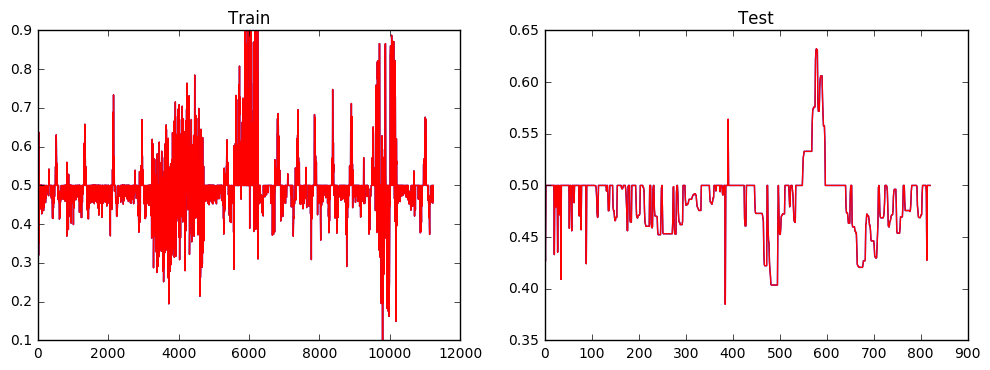

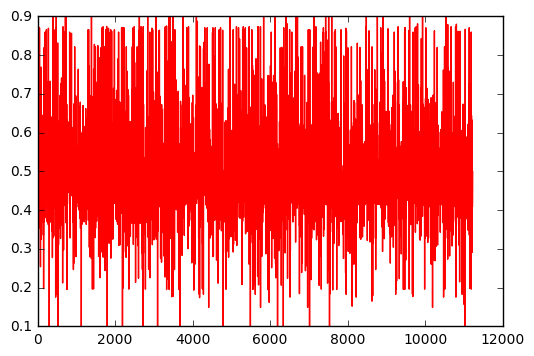

11224
0.484904


In [4]:
# User zero phase filter so that no phase shift occurs.
# Originally used filter since was using keyboard inputs that gave too sharp of inputs.
# However filter is no longer used since I was able to use a controller to produce the input.
# Setting a butter worth filter to (1, 1) has no effect on output but I kept it incase I needed to 
# run the keyboard data again.

b, a = signal.butter(1, 1) # previously 0.1
y_train_zero = signal.filtfilt(b, a, y_train, padlen=20)

y_test_zero = signal.filtfilt(b, a, y_test, padlen=20)

y_train_zero = y_train_zero.astype('float32')
y_test_zero = y_test_zero.astype('float32')

print(type(y_test_zero[0]))
print(type(y_train_zero[0]))




fig = plt.figure(figsize=(12, 4))
figinfo = fig.add_subplot(1,2,1)
plt.plot(y_train[:],'b')
plt.plot(y_train_zero[:],'r')
figinfo.set_title('Train')
#figinfo.set_xlim([5583,6266])
#figinfo.set_xlim([820,835])
#figinfo.set_xlim([900,1200])

figinfo=fig.add_subplot(1,2,2)
plt.plot(y_test)
plt.plot(y_test_zero,'r')
figinfo.set_title('Test')
plt.show()





#X_train_reshape = X_train_norm.reshape(len(X_train_norm), 153600)
#X_test_reshape = X_test_norm.reshape(len(X_test_norm), 153600)

X_train_final, X_valid_final, y_train_final, y_valid_final = train_test_split(
                                        X_train_norm, y_train_zero, test_size=0, random_state=1337)

plt.plot(y_train_final, 'r')
plt.show()

print(len(y_train_final))
print(y_train_zero[3])

In [6]:
# Reduce Memory Load
y_train_zero = None
y_test_zero = None

# Keras Convolution NN

In [3]:
# Create model.

# Convolution kernal size.
kernal_size = (3,3)

# Convolution filters
nb_filters = 12
pool_size = (2,2)
input_shape = (95,320,3)

model = Sequential()

# First convolution layer with max pooling and dropout.
model.add(Convolution2D(nb_filters*2, kernal_size[0]*2, kernal_size[1]*2,
                       border_mode = 'valid',
                       input_shape = input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

# Second convolution layer with max pooling and dropout.
model.add(Convolution2D(nb_filters*3, kernal_size[0]*2, kernal_size[1]*2,
                       border_mode = 'valid',
                       input_shape = input_shape))
model.add(Activation('linear'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

# Third convolution layer with max pooling and dropout.
model.add(Convolution2D(nb_filters*4, kernal_size[0], kernal_size[1],
                       border_mode = 'valid',
                       input_shape = input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

# Fourth convolution layer with max pooling and dropout.
model.add(Convolution2D(64, kernal_size[0], kernal_size[1],
                       border_mode = 'valid',
                       input_shape = input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

# fifth convolution layer with max pooling and dropout.
model.add(Convolution2D(64, kernal_size[0], kernal_size[1],
                       border_mode = 'valid',
                       input_shape = input_shape))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())

# First deep layer.
model.add(Dense(1024)) #, input_shape=(153600,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Second deep layer.
model.add(Dense(128))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

# Third deep layer.
model.add(Dense(64)) 
model.add(Activation('relu'))
#model.add(Dropout(0.5))

# Fourth deep layer.
model.add(Dense(16)) 
model.add(Activation('relu'))
#model.add(Dropout(0.5))

# Final output layer.
model.add(Dense(1))


model.summary()

plot(model, to_file='model.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_6 (Convolution2D)  (None, 90, 315, 24)   2616        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 90, 315, 24)   0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 45, 157, 24)   0           activation_10[0][0]              
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 45, 157, 24)   0           maxpooling2d_5[0][0]             
___________________________________________________________________________________________

Before this there was 40 epochs.
Train on 9540 samples, validate on 1684 samples
Epoch 1/5
9540/9540 [==============================] - 16s - loss: 0.0015 - mean_absolute_error: 0.0245 - val_loss: 0.0017 - val_mean_absolute_error: 0.0236
Epoch 2/5
9540/9540 [==============================] - 15s - loss: 0.0015 - mean_absolute_error: 0.0247 - val_loss: 0.0017 - val_mean_absolute_error: 0.0242
Epoch 3/5
9540/9540 [==============================] - 15s - loss: 0.0015 - mean_absolute_error: 0.0242 - val_loss: 0.0017 - val_mean_absolute_error: 0.0237
Epoch 4/5
9540/9540 [==============================] - 15s - loss: 0.0015 - mean_absolute_error: 0.0244 - val_loss: 0.0017 - val_mean_absolute_error: 0.0240
Epoch 5/5
9540/9540 [==============================] - 15s - loss: 0.0015 - mean_absolute_error: 0.0243 - val_loss: 0.0017 - val_mean_absolute_error: 0.0236
Done.
1.5 minutes.


821/821 [==============================] - 0s     


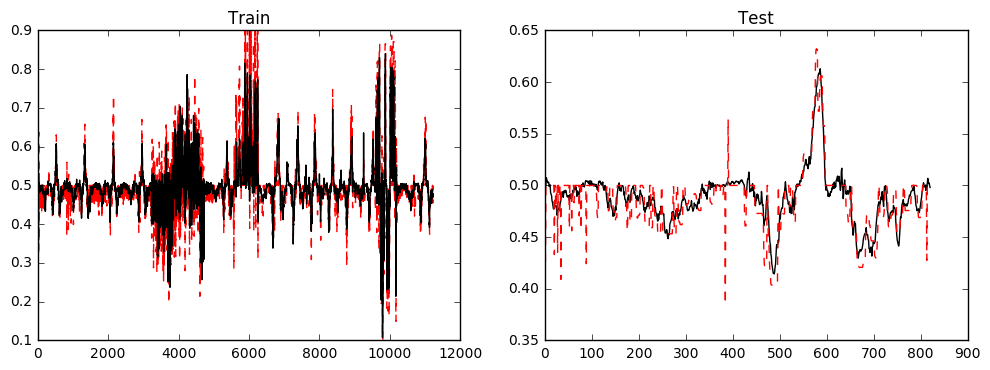

In [45]:
nb_epoch = 5
print('Before this there was 40 epochs.')

batch_size = 32

starttime = time.clock()

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.00005), metrics=['mean_absolute_error'] )
#optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) )#metrics=['mean_squared_error'])

#history = model.fit(X_train_norm[5583:6266], y_train_zero[5583:6266],
#                    batch_size = batch_size, nb_epoch = nb_epoch,
#                    verbose = 1, validation_split=0)

history = model.fit(X_train_final, y_train_final,
                    batch_size = batch_size, nb_epoch = nb_epoch,
                    verbose = 1, validation_split=0.15)

print("Done.")

elapsedtime = time.clock() - starttime

#print('%.2f seconds.' %elapsedtime)
print('%.1f minutes.\n\n' %(elapsedtime/60))

trainsteering = model.predict( X_train_norm, batch_size=100, verbose=1)
teststeering = model.predict( X_test_norm, batch_size=100, verbose=1)

fig = plt.figure(figsize=(12, 4))
figinfo = fig.add_subplot(1,2,1)
figinfo.set_title('Train')
plt.plot(y_train,'r--')
plt.plot(trainsteering,'k')
#figinfo.set_xlim([3000,5000]) # corner correct
#figinfo.set_xlim([5583,6266]) # Hard right.


figinfo = fig.add_subplot(1,2,2)
plt.plot(teststeering,'k')
plt.plot(y_test,'r--')
figinfo.set_title('Test')
plt.show()

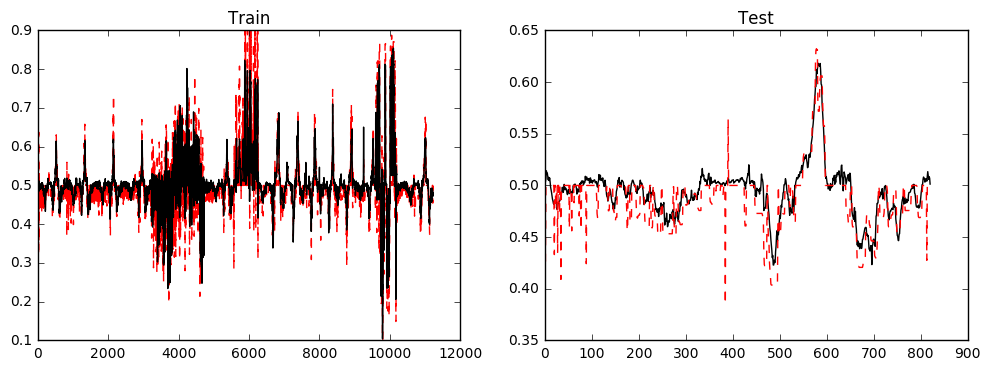

0.0 minutes.


In [30]:
starttime = time.clock()


fig = plt.figure(figsize=(12, 4))
figinfo = fig.add_subplot(1,2,1)
figinfo.set_title('Train')
plt.plot(y_train,'r--')
plt.plot(trainsteering,'k')
#figinfo.set_xlim([3000,5000]) # corner correct
#figinfo.set_xlim([5583,6266]) # Hard right.


figinfo = fig.add_subplot(1,2,2)
plt.plot(teststeering,'k')
plt.plot(y_test,'r--')
figinfo.set_title('Test')
plt.show()

elapsedtime = time.clock() - starttime

#print('%.2f seconds.' %elapsedtime)
print('%.1f minutes.' %(elapsedtime/60))

In [39]:
#score = model.evaluate(X_test_norm, y_test_zero, verbose=2)
#print('Test Score:',score)
#print('Test Mean Absolute Error:', score[1])

print(trainsteering[0:10])

[[ 0.50030249]
 [ 0.49901596]
 [ 0.49808562]
 [ 0.49737078]
 [ 0.49889627]
 [ 0.49741238]
 [ 0.50138253]
 [ 0.50212222]
 [ 0.50338131]
 [ 0.50159359]]


In [46]:
savemodel = 1

if savemodel == 1:
    model.save_weights('model.h5')
    model_json = model.to_json()
    #with open("model.json", "w") as json_file:
    #    json_file.write(model_json)
        
    with open('model.json', 'w') as f:
        json.dump(model_json, f)
        
    print("Architecture and weights saved.")

Architecture and weights saved.
